In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import IPython
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [14]:
import librosa
import librosa.display
import soundfile as sf
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

In [3]:
np.random.seed(18)

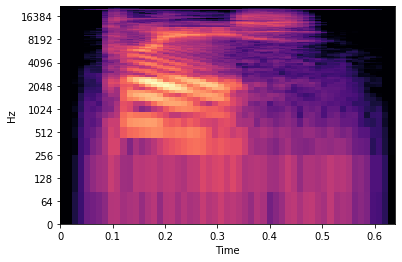

In [5]:
y, sr= librosa.core.load("./please.wav", 44100)
S = librosa.feature.melspectrogram(y=y, sr=sr)
S_db = librosa.core.power_to_db(S)

fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
librosa.display.specshow(S_db, y_axis='log', sr=sr, x_axis='time', ax=ax)

In [20]:
class CustomDataset(Dataset):
	def __init__(
		self, 
		wake_word_path, 
		background_sounds_root_path = "C:/Users/DACUS/Desktop/UrbanSound8K/audio/fold1",
		max_length = 4,
		sampling_rate = 44100 #44.1 Hz
		):
		self.wake_word_path = wake_word_path
		self.sampling_rate = sampling_rate
		self.background_sounds_root_path = background_sounds_root_path
		self.background_noise_sound_paths =  list(pathlib.Path(background_sounds_root_path).glob('*.wav'))
		self.generated_samples = []

		sample_size = sampling_rate * max_length
		
		self.wake_word, _ = librosa.core.load(self.wake_word_path, sr=sampling_rate)
		self.wake_word = np.pad(self.wake_word, (0, 2 * sampling_rate - len(self.wake_word)))
		
		if len(self.wake_word) > sample_size:
			raise Exception(f"Wake word size {len(self.wake_word)} bigger than the background noise max length {sample_size}")

		for idx, path in enumerate(self.background_noise_sound_paths[:1]):
			y, sr = librosa.core.load(path, sr=sampling_rate)

			if len(y) < sample_size:
				y = np.pad(y, (0, sample_size - len(y)))
			else:
				y = y[:sample_size]

			interval = self._get_random_time_interval(len(self.wake_word), max_length * sampling_rate)
			self._overlay_wakeword(y[interval[0]:interval[1]], self.wake_word)
			# self._save_sound(y)

			S = librosa.feature.melspectrogram(y=y, sr=sr)
			S_db = librosa.core.power_to_db(S)

			label = np.zeros(sample_size)
			label[interval[1]:interval[1] + 50] = 1

			self.generated_samples.append((S_db, label))
				

	def __getitem__(self, idx):
		return self.generated_samples[idx]

	def _get_random_time_interval(self, interval_size, max_size):
		interval_start = np.random.randint(low=0, high=max_size - interval_size)
		interval_end = interval_start + interval_size

		return interval_start, interval_end

	def _overlay_wakeword(self, background, addition):
		background += addition
		background /= 2

	def _save_sound(self, data, name="generated_file.wav"):
		sf.write(name, data, self.sampling_rate)

	def __len__(self):
		return len(self.background_noise_sound_paths)

In [22]:
dataset = CustomDataset("please.wav")
sample = dataset[0][0]
np.where(sample == 1)

(array([], dtype=int64), array([], dtype=int64))